In [1]:
import numpy as np
from matplotlib import pyplot as plt
from torch import autograd
import pandas
import sklearn.preprocessing
from sklearn.metrics import mean_squared_error
import datetime

np.random.seed(0)

## Read data and initialize dataset

In [2]:
users = pandas.read_csv('Project2-data/users.txt', header=None).to_numpy()
train = pandas.read_csv('Project2-data/netflix_train.txt', sep=' ', header=None).to_numpy()[:,0:3].astype(np.int32)
test = pandas.read_csv('Project2-data/netflix_test.txt', sep=' ', header=None).to_numpy()[:,0:3].astype(np.int32)

In [3]:
real_user_ids = users.reshape([10000])
real_movie_ids = np.array(range(1,10001))

In [4]:
user_id_encoder = sklearn.preprocessing.LabelEncoder()
movie_id_encoder = sklearn.preprocessing.LabelEncoder()
user_id_encoder.fit(real_user_ids)
movie_id_encoder.fit(real_movie_ids)

LabelEncoder()

In [5]:
train[:,0] = user_id_encoder.transform(train[:,0])
test[:,0] = user_id_encoder.transform(test[:,0])
train[:,1] = movie_id_encoder.transform(train[:,1])
test[:,1] = movie_id_encoder.transform(test[:,1])

In [6]:
X_train = np.zeros([10000,10000])
X_test = np.zeros([10000,10000])

In [7]:
for t in train:
    X_train[t[0]][t[1]] = t[2]
for t in test:
    X_test[t[0]][t[1]] = t[2]

In [8]:
def rmse(pred, act):
    return np.sqrt(mean_squared_error(pred, act))

## Sanity check: RMSE of random / all 3

In [9]:
print('All 3: ', rmse(np.ones(test[:,2].shape) * 3, test[:,2]))
print('Random: ', rmse(np.random.randint(1,6,len(test[:,2])), test[:,2]))

All 3:  1.1715111196739934
Random:  1.8360044249231986


## Collaborative filtering

In [10]:
X_train_normalized_users = sklearn.preprocessing.normalize(X_train, axis=1, norm='l2')
user_similarities = X_train_normalized_users.dot(X_train_normalized_users.T) # gram matrix

In [11]:
def score(X, i, j, k_value=5):
    indices_of_users_who_have_rated_the_movie = X_train[:,j] != 0
    similarities_of_users_who_have_rated_the_movie = user_similarities[i][indices_of_users_who_have_rated_the_movie]
    k_value = min(k_value, len(similarities_of_users_who_have_rated_the_movie))
    indices_of_highest_similarities = np.argpartition(similarities_of_users_who_have_rated_the_movie, -k_value)[-k_value:]
    indices_of_users_with_highest_similarities = (np.array(range(10000))[indices_of_users_who_have_rated_the_movie])[indices_of_highest_similarities]
    
    similarities = user_similarities[i][indices_of_users_with_highest_similarities]
    user_scores = X[indices_of_users_with_highest_similarities, j]
    denom = np.sum(similarities)
    num = user_scores.dot(similarities)
    return num/denom

**Choosing k**

In [12]:
for k_value_this_iter in [1,5,10,25,50,100,200]:
    predicted = np.array(list(map(
        lambda td: score(X_train, td[0], td[1], k_value_this_iter),
        test
    )))
    print(f'{k_value_this_iter}, {rmse(predicted, test[:,2])}')

1, 1.2714758160785657
5, 1.0152092267427844
10, 0.9807274455467773
25, 0.9643775475741438
50, 0.9626898274212521
100, 0.9657480558816877
200, 0.9715509512447946


In [13]:
# the 25-100 range looks promising
for k_value_this_iter in [37,62,75,87]:
    predicted = np.array(list(map(
        lambda td: score(X_train, td[0], td[1], k_value_this_iter),
        test
    )))
    print(f'{k_value_this_iter}, {rmse(predicted, test[:,2])}')

37, 0.9626310311967199
62, 0.9632290672374707
75, 0.9640393962103675
87, 0.9648446626312764


**Using the best value of k (k=37)**

In [17]:
best_k_value = 37

print(datetime.datetime.now())
predicted = np.array(list(map(
    lambda td: score(X_train, td[0], td[1], best_k_value),
    test
)))
print(rmse(predicted, test[:,2]))
print(datetime.datetime.now())

2022-11-20 15:12:50.243102
0.9626310311967199
2022-11-20 15:57:49.010321


## Matrix decomposition

In [9]:
A = X_train.copy()
A[A != 0] = 1
norm = np.linalg.norm
U0, s0, V0 = np.linalg.svd(X_train)
V0 = np.matmul(np.diag(s0), V0)

In [11]:
def calculate_J(A, X, U, V, l):
    return (
        (0.5 * np.square(norm(
            A * (X - np.matmul(U, V.T))
        ))) +
        (l * np.square(norm(U))) +
        (l * np.square(norm(V)))
    )

def calculate_dJ_dU(A, X, U, V, l):
    return 2 * l * U + (
        np.matmul(
            A * (np.matmul(U, V.T) - X),
            V
        )
    )

def calculate_dJ_dV(A, X, U, V, l):
    return 2 * l * V + (
        np.matmul(
            (A * (np.matmul(U, V.T) - X)).T,
            U
        )
    )

def calculate_rmse(A, X, U, V):
    return np.sqrt(np.mean(np.square(A * (X - np.matmul(U, V.T)))))

In [12]:
a = 1e-7
l = 0.01
k = 50

def run_decomp_algo(original_a, l, k):
    a = original_a
    print(f'a={a} l={l} k={k} started at {datetime.datetime.now()}')
    
    U = U0[:, :k]
    V = V0[:k, :].T

    cur_iter = 0
    rmses = []
    Js = []
    while(True):
        if cur_iter % 10 == 0:
            rmse = calculate_rmse(A, X_train, U, V)
            J = calculate_J(A, X_train, U, V, l)
            print(f'Iter {cur_iter}, rmse {rmse}, J {J}')
            rmses.append(rmse)
            Js.append(J)
            
        cur_iter += 1
        
        U = U - a * calculate_dJ_dU(A, X_train, U, V, l)
        V = V - a * calculate_dJ_dV(A, X_train, U, V, l)

        a = a * 0.995
        
        if len(Js) > 10 and Js[-1] + 1000 > Js[-10]:
            print(f'a={original_a} l={l} k={k} converged with rmse={rmse} J={J} at {datetime.datetime.now()} on iter {cur_iter}')
            return rmses, Js
            
rmses, Js = run_decomp_algo(a, l, k)

a=1e-07 l=0.01 k=50 started at 2022-11-21 12:32:09.808193
Iter 0, rmse 0.5452540103054142, J 15287487.056711528
Iter 10, rmse 0.42383454446100777, J 9404176.401084531
Iter 20, rmse 0.40563723667706186, J 8649468.803601569
Iter 30, rmse 0.39150870817030836, J 8086343.905118555
Iter 40, rmse 0.37517188492468717, J 7460087.699933263
Iter 50, rmse 0.364250508669386, J 7056312.252754062
Iter 60, rmse 0.3564274627200617, J 6774417.466094478
Iter 70, rmse 0.3499631496824622, J 6546101.017166847
Iter 80, rmse 0.3445137455210868, J 6356876.802342609
Iter 90, rmse 0.3398648237703475, J 6197795.7270634
Iter 100, rmse 0.33585839863029343, J 6062434.043831903
Iter 110, rmse 0.3323752580659103, J 5946056.494890692
Iter 120, rmse 0.3293237090787238, J 5845096.190172253
Iter 130, rmse 0.3266320709455668, J 5756816.443862963
Iter 140, rmse 0.32424351479924785, J 5679083.830619856
Iter 150, rmse 0.32211242651716754, J 5610211.780547413
Iter 160, rmse 0.3202017886554125, J 5548850.314123424
Iter 170, rms

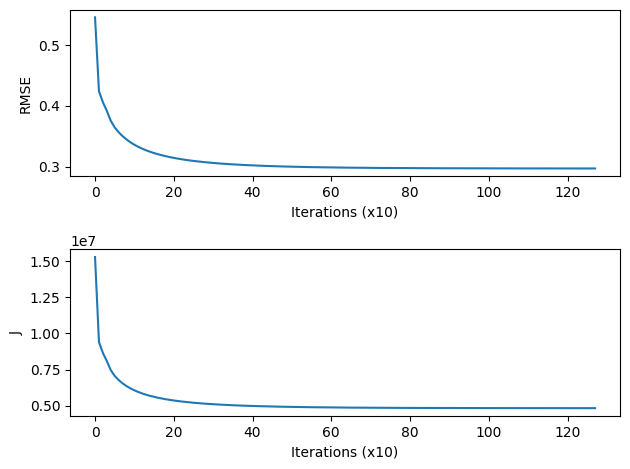

In [25]:
plt.subplot(2,1,1)
plt.plot(rmses)
plt.xlabel('Iterations (x10)')
plt.ylabel('RMSE')
plt.subplot(2,1,2)
plt.plot(Js)
plt.xlabel('Iterations (x10)')
plt.ylabel('J')
plt.tight_layout()
plt.show()

In [28]:
results = {10: dict(), 50: dict(), 100: dict()}

for k in [10,50,100]:
    for l in [0.001, 0.01, 0.1, 1]:
        rs, _ = run_decomp_algo(original_a=1e-7, l=l, k=k)
        final_rmse = rs[-1]
        results[k][l] = final_rmse

a=1e-07 l=0.001 k=10 started at 2022-11-21 15:05:52.107576
Iter 0, rmse 0.5904811596276496, J 17470504.02740631
Iter 10, rmse 0.45382943983070256, J 10335162.065080041
Iter 20, rmse 0.4345593587567204, J 9479195.864530599
Iter 30, rmse 0.4192978294592052, J 8827637.547741454
Iter 40, rmse 0.40214641869500023, J 8123191.169864726
Iter 50, rmse 0.39078815204507267, J 7672873.063572148
Iter 60, rmse 0.38268630088796624, J 7359544.326861392
Iter 70, rmse 0.37603130754816666, J 7107081.302729832
Iter 80, rmse 0.3704592532389343, J 6899107.012389327
Iter 90, rmse 0.36574195219474454, J 6725462.883150179
Iter 100, rmse 0.3617107954255699, J 6578839.085849613
Iter 110, rmse 0.3582380657623085, J 6453829.703221601
Iter 120, rmse 0.35522512244461735, J 6346348.501260244
Iter 130, rmse 0.3525945493401246, J 6253249.936637197
Iter 140, rmse 0.3502847598800383, J 6172074.780245475
Iter 150, rmse 0.3482461869309881, J 6100874.469939635
Iter 160, rmse 0.3464385296710293, J 6038086.880391274
Iter 170,

In [31]:
results

{10: {0.001: 0.3269508957911972,
  0.01: 0.3269509154535859,
  0.1: 0.3269511120788796,
  1: 0.32695307847179156},
 50: {0.001: 0.29685364017012555,
  0.01: 0.29685366171682326,
  0.1: 0.2968538771854426,
  1: 0.2968560320351759},
 100: {0.001: 0.2912364088129185,
  0.01: 0.2912364255914613,
  0.1: 0.29123659337910396,
  1: 0.29123533145766267}}

In [42]:
output = ''
for k in [10,50,100]:
    output += str(k)+'&'
    for l in [0.001, 0.01, 0.1, 1]:
        output += str(results[k][l])[:10] + '&'
    output = output[:-1] + '\\\\\n'
print(output)

10&0.32695089&0.32695091&0.32695111&0.32695307\\
50&0.29685364&0.29685366&0.29685387&0.29685603\\
100&0.29123640&0.29123642&0.29123659&0.29123533\\



 **Testing with the best set of hyperparameters**

In [ ]:
A = X_train.copy()
A[A != 0] = 1
norm = np.linalg.norm
U0, s0, V0 = np.linalg.svd(X_train)
V0 = np.matmul(np.diag(s0), V0)

In [ ]:
a = 1e-7
l = 1
k = 100

print(f'a={a} l={l} k={k} started at {datetime.datetime.now()}')

U = U0[:, :k]
V = V0[:k, :].T

cur_iter = 0
rmses = []
Js = []
while(True):
    if cur_iter % 10 == 0:
        rmse = calculate_rmse(A, X_train, U, V)
        J = calculate_J(A, X_train, U, V, l)
        print(f'Iter {cur_iter}, rmse {rmse}, J {J}')
        rmses.append(rmse)
        Js.append(J)

    cur_iter += 1

    U = U - a * calculate_dJ_dU(A, X_train, U, V, l)
    V = V - a * calculate_dJ_dV(A, X_train, U, V, l)

    a = a * 0.995

    if len(Js) > 10 and Js[-1] + 1000 > Js[-10]:
        print(f'a={a} l={l} k={k} converged with rmse={rmse} J={J} at {datetime.datetime.now()} on iter {cur_iter}')

In [ ]:
A_test = X_test.copy()
A_test[A_test != 0] = 1

In [26]:
np.sqrt(np.mean(np.square(A_test * (X_test - np.matmul(U, V.T)))))

0.15819487975810678

## Optional Content

In [9]:
users = pandas.read_csv('Project2-data/users.txt', header=None).to_numpy()
train = pandas.read_csv('Project2-data/netflix_train.txt', sep=' ', header=None)
test = pandas.read_csv('Project2-data/netflix_test.txt', sep=' ', header=None)

In [10]:
train[3] = train[3].map(lambda x: int(x[:4]))
train = train.to_numpy().astype(np.int32)
test[3] = test[3].map(lambda x: int(x[:4]))
test = test.to_numpy().astype(np.int32)

In [11]:
real_user_ids = users.reshape([10000])
real_movie_ids = np.array(range(1,10001))
user_id_encoder = sklearn.preprocessing.LabelEncoder()
movie_id_encoder = sklearn.preprocessing.LabelEncoder()
user_id_encoder.fit(real_user_ids)
movie_id_encoder.fit(real_movie_ids)
train[:,0] = user_id_encoder.transform(train[:,0])
test[:,0] = user_id_encoder.transform(test[:,0])
train[:,1] = movie_id_encoder.transform(train[:,1])
test[:,1] = movie_id_encoder.transform(test[:,1])

In [12]:
min(train[:,3]), max(train[:,3]), min(test[:,3]), max(test[:,3])

(1999, 2005, 1999, 2005)

In [13]:
X_train = np.zeros([10000,10000])
X_test = np.zeros([10000,10000])
X_train_99 = np.zeros([10000, 10000])
X_train_05 = np.zeros([10000, 10000])
for t in train:
    X_train[t[0]][t[1]] = t[2]
    if t[3] != 2005:
        X_train_99[t[0]][t[1]] = t[2]
    if t[3] != 1999:
        X_train_05[t[0]][t[1]] = t[2]
for t in test:
    X_test[t[0]][t[1]] = t[2]

In [14]:
X_train_normalized_users = sklearn.preprocessing.normalize(X_train, axis=1, norm='l2')
user_similarities = X_train_normalized_users.dot(X_train_normalized_users.T) # gram matrix

X_train_normalized_users_99 = sklearn.preprocessing.normalize(X_train_99, axis=1, norm='l2')
user_similarities_99 = X_train_normalized_users_99.dot(X_train_normalized_users_99.T) # gram matrix
X_train_normalized_users_05 = sklearn.preprocessing.normalize(X_train_05, axis=1, norm='l2')
user_similarities_05 = X_train_normalized_users_05.dot(X_train_normalized_users_05.T) # gram matrix

def score(X, i, j, year, k_value=5):
    if year == 1999:
        Xt = X_train_99
        us = user_similarities_99
    elif year == 2005:
        Xt = X_train_05
        us = user_similarities_05
    else:
        Xt = X_train
        us = user_similarities
    
    indices_of_users_who_have_rated_the_movie = Xt[:,j] != 0
    similarities_of_users_who_have_rated_the_movie = us[i][indices_of_users_who_have_rated_the_movie]
    k_value = min(k_value, len(similarities_of_users_who_have_rated_the_movie))
    indices_of_highest_similarities = np.argpartition(similarities_of_users_who_have_rated_the_movie, -k_value)[-k_value:]
    indices_of_users_with_highest_similarities = (np.array(range(10000))[indices_of_users_who_have_rated_the_movie])[indices_of_highest_similarities]
    
    similarities = us[i][indices_of_users_with_highest_similarities]
    user_scores = X[indices_of_users_with_highest_similarities, j]
    denom = np.sum(similarities)
    num = user_scores.dot(similarities)
    return num/denom
best_k_value = 37

print(datetime.datetime.now())
predicted = np.array(list(map(
    lambda td: score(X_train, td[0], td[1], td[3], best_k_value),
    test
)))
print(rmse(predicted, test[:,2]))
print(datetime.datetime.now())

2022-11-23 14:38:14.081643
0.9626311601015174
2022-11-23 15:26:11.430782
